In [0]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch

from tqdm import tqdm

import math

import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Вспомогательные математические функции с https://github.com/mariogeiger/hessian

def gradient(outputs, inputs, grad_outputs=None, retain_graph=None, create_graph=False):
    '''
    Compute the gradient of `outputs` with respect to `inputs`
    gradient(x.sum(), x)
    gradient((x * y).sum(), [x, y])
    '''
    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)
    grads = torch.autograd.grad(outputs, inputs, grad_outputs,
                                allow_unused=True,
                                retain_graph=retain_graph,
                                create_graph=create_graph)
    grads = [x if x is not None else torch.zeros_like(y) for x, y in zip(grads, inputs)]
    return torch.cat([x.contiguous().view(-1) for x in grads])


def hessian(output, inputs, out=None, allow_unused=False, create_graph=False):
    '''
    Compute the Hessian of `output` with respect to `inputs`
    hessian((x * y).sum(), [x, y])
    '''
    assert output.ndimension() == 0

    if torch.is_tensor(inputs):
        inputs = [inputs]
    else:
        inputs = list(inputs)

    n = sum(p.numel() for p in inputs)
    if out is None:
        out = output.new_zeros(n, n)

    ai = 0
    for i, inp in enumerate(inputs):
        [grad] = torch.autograd.grad(output, inp, create_graph=True, allow_unused=allow_unused)
        grad = torch.zeros_like(inp) if grad is None else grad
        grad = grad.contiguous().view(-1)

        for j in range(inp.numel()):
            if grad[j].requires_grad:
                row = gradient(grad[j], inputs[i:], retain_graph=True, create_graph=create_graph)[j:]
            else:
                row = grad[j].new_zeros(sum(x.numel() for x in inputs[i:]) - j)

            out[ai, ai:].add_(row.type_as(out))  # ai's row
            if ai + 1 < n:
                out[ai + 1:, ai].add_(row[1:].type_as(out))  # ai's column
            del row
            ai += 1
        del grad

    return out

In [0]:
# Устанавливаем параметры для графиков

parameters = {
    'figure.figsize': (14.0, 8.0),
    'font.size': 18,
    'axes.titlesize': 24,
    'axes.labelsize': 24,
    'legend.fontsize': 24,
    'xtick.labelsize': 24,
    'ytick.labelsize': 24,
    'lines.linewidth': 2,
    'lines.markersize': 4
}

plt.rcParams.update(parameters)

In [4]:
# Создадим экземпляр вычислительной машины и посмотрим на него

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# **Эксперименты**

Проведены на простой синтетической выборке: $$x\sim \mathcal{N}(0, I_n),\ w\sim \mathcal{N}(0, I_n),\ y\sim \mathcal{N}(w^Tx, \sigma I).$$

In [0]:
# Синтезируем данные
m_samples = 512
n = 30
sigma = 0.001

w = np.random.randn(n)

X_train = np.random.randn(m_samples, n)
Y_train = (X_train @ w + sigma * np.random.randn(m_samples)).reshape([-1, 1])

X_test = np.random.randn(m_samples, n)
Y_test = (X_test @ w + sigma * np.random.randn(m_samples)).reshape([-1, 1])

In [0]:
# Загружаем данные на машину
train_data = TensorDataset(torch.Tensor(X_train).to(device), torch.Tensor(Y_train).to(device))
test_data = TensorDataset(torch.Tensor(X_test).to(device), torch.Tensor(Y_test).to(device))

X_tr, Y_tr = train_data[:]
X_ts, Y_ts = test_data[:]

Модель --- MLP (полносвязная нейросеть) с одним скрытым слоем и разным количеством нейронов на нём.

In [0]:
class MLP1(torch.nn.Module):
    def __init__(self, input_dim=30, hidden_dim=5, output_dim=1, device='cpu'):
        super(MLP1, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.device = device

        self.body = torch.nn.Sequential(
            torch.nn.Linear(self.input_dim, self.hidden_dim),
            torch.nn.LeakyReLU(),
        )
        
        self.head = torch.nn.Linear(self.hidden_dim, self.output_dim)
        
        list_w = []
        for w in self.parameters():
            list_w.append(w.data.view(-1))
        self.D = len(torch.cat(list_w).view(-1))
        self.S = torch.Tensor([0.5 * 1 * (1 + 2 * math.pi)]).mean().to(device)

        self.to(device)

    def predict(self, input):
        return self.head(self.body(input))
    
    def log_prior_w(self, w):
        sigma = 1.
        w = w.view(-1)
        return -0.5 * (sigma ** 2) * torch.dot(w, w) - 0.5 * len(w) * math.log(2 * math.pi)+len(w) * math.log(sigma)
      
    def log_prior_all(self):
        temp = 0
        for w in self.parameters():
            temp += self.log_prior_w(w)
        return temp
     
    def log_likelihood(self, batch_x, batch_y):
        beta = 1.
        batch_size = len(batch_y)
        return -0.5 * beta * torch.sum((self.predict(batch_x) - batch_y)**2)- 0.5 * batch_size*math.log(2 * math.pi) + 0.5 * batch_size * math.log(beta)
    
    def margin_log_likelihood(self, batch_x, batch_y):
        return (self.log_prior_all() + self.log_likelihood(batch_x, batch_y)) / len(batch_y)
    
    def batch_loss(self, batch_x, batch_y):
        return torch.mean((self.predict(batch_x) - batch_y)**2)
    

Построим графики зависимости обоснованности модели от номера эпохи для разных размерностей скрытого слоя.

### Простая модель
Один нейрон на скрытом слое, такая модель близка к линейной.

100%|██████████| 1000/1000 [02:40<00:00,  6.19it/s]


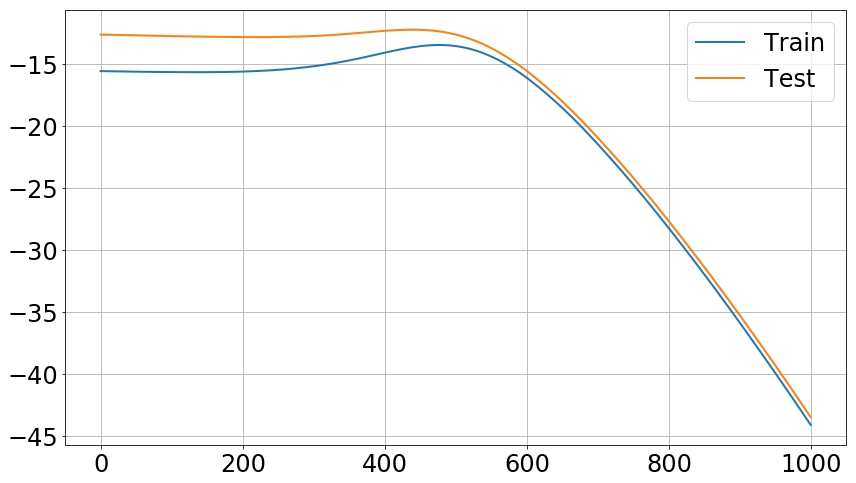

In [8]:
model = MLP1(input_dim=n, output_dim=1, hidden_dim=1)
steps_list = []

for epoch in tqdm(range(1000)):
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    for batch_x, batch_y in generator:
        
        model.zero_grad()
        margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

        list_w = []
        for w in model.parameters():
            list_w.append(w)

        lr=0.0001
        model.S = (model.S + torch.log(torch.det(torch.eye(model.D, device=device) - lr * hessian(margin_log_likelihood, list_w)))).detach()
    
        model.zero_grad()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        batch_loss = model.batch_loss(batch_x, batch_y)
        batch_loss.backward()

        optimizer.step()

    steps_list.append((model.S.item(), model.log_prior_all().item(), len(Y_tr), 
                       model.log_likelihood(X_tr, Y_tr).item(), len(Y_ts), model.log_likelihood(X_ts, Y_ts).item()))
        
        
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in steps_list], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in steps_list], label = 'Test')

plt.grid()
plt.legend(loc='best')
plt.show()

Обоснованность начинает резко падать после 500 эпохи, а до этого её рост незначителен (линейная модель). Потому что энтропия убывает гораздо сильнее, чем растёт правдоподобие.


### Менее простая модель

Три нейрона на скрытом слое.

100%|██████████| 1000/1000 [07:43<00:00,  2.19it/s]


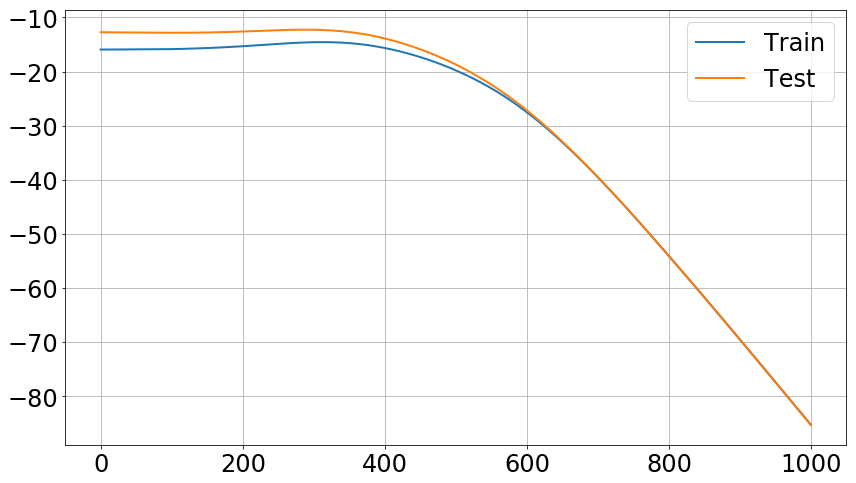

In [9]:
model = MLP1(input_dim=n, output_dim=1, hidden_dim=3)
steps_list = []

for epoch in tqdm(range(1000)):
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    for batch_x, batch_y in generator:
        
        model.zero_grad()
        margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

        list_w = []
        for w in model.parameters():
            list_w.append(w)

        lr=0.0001
        model.S = (model.S + torch.log(torch.det(torch.eye(model.D, device=device) - lr * hessian(margin_log_likelihood, list_w)))).detach()
    
        model.zero_grad()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        batch_loss = model.batch_loss(batch_x, batch_y)
        batch_loss.backward()

        optimizer.step()

    steps_list.append((model.S.item(), model.log_prior_all().item(), len(Y_tr), 
                       model.log_likelihood(X_tr, Y_tr).item(), len(Y_ts), model.log_likelihood(X_ts, Y_ts).item()))
        
        
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in steps_list], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in steps_list], label = 'Test')

plt.grid()
plt.legend(loc='best')
plt.show()

Обоснованность начинает резко падать после примерно 350 эпохи. Потому что энтропия убывает гораздо сильнее, чем растёт правдоподобие.

### Средняя модель
Шесть нейронов на скрытом слое.

100%|██████████| 1000/1000 [14:44<00:00,  1.14it/s]


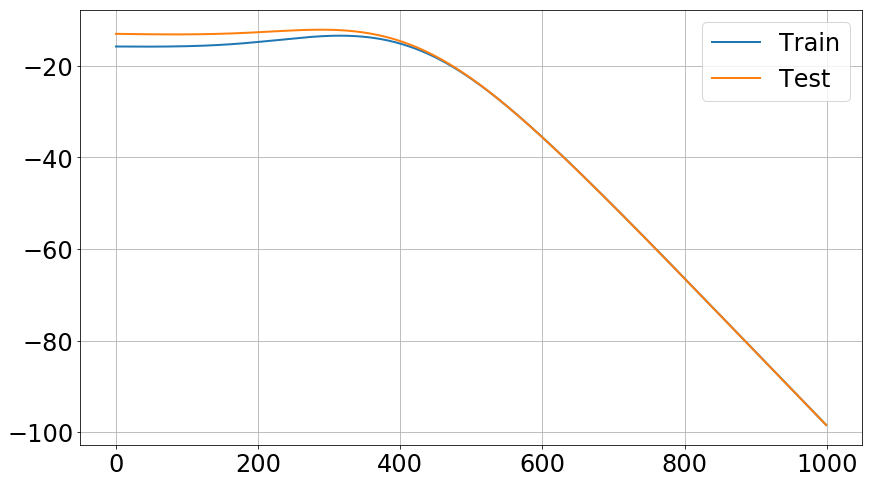

In [10]:
model = MLP1(input_dim=n, output_dim=1, hidden_dim=6)
steps_list = []

for epoch in tqdm(range(1000)):
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    for batch_x, batch_y in generator:
        
        model.zero_grad()
        margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

        list_w = []
        for w in model.parameters():
            list_w.append(w)

        lr=0.0001
        model.S = (model.S + torch.log(torch.det(torch.eye(model.D, device=device) - lr * hessian(margin_log_likelihood, list_w)))).detach()
    
        model.zero_grad()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        batch_loss = model.batch_loss(batch_x, batch_y)
        batch_loss.backward()

        optimizer.step()

    steps_list.append((model.S.item(), model.log_prior_all().item(), len(Y_tr), 
                       model.log_likelihood(X_tr, Y_tr).item(), len(Y_ts), model.log_likelihood(X_ts, Y_ts).item()))
        
        
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in steps_list], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in steps_list], label = 'Test')

plt.grid()
plt.legend(loc='best')
plt.show()

Обоснованность начинает  падать после 300 эпохи. Потому что энтропия убывает гораздо сильнее, чем растёт правдоподобие.

### Сложная модель
Пятнадцать нейронов на скрытом слое.


100%|██████████| 400/400 [14:46<00:00,  2.20s/it]


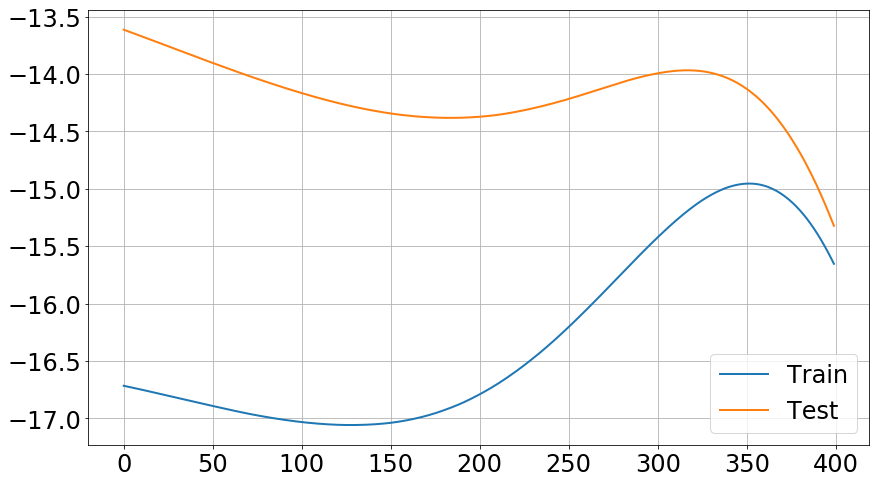

In [12]:
model = MLP1(input_dim=n, output_dim=1, hidden_dim=15)
steps_list = []

for epoch in tqdm(range(400)):
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    for batch_x, batch_y in generator:
        
        model.zero_grad()
        margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

        list_w = []
        for w in model.parameters():
            list_w.append(w)

        lr=0.0001
        model.S = (model.S + torch.log(torch.det(torch.eye(model.D, device=device) - lr * hessian(margin_log_likelihood, list_w)))).detach()
    
        model.zero_grad()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        batch_loss = model.batch_loss(batch_x, batch_y)
        batch_loss.backward()

        optimizer.step()

    steps_list.append((model.S.item(), model.log_prior_all().item(), len(Y_tr), 
                       model.log_likelihood(X_tr, Y_tr).item(), len(Y_ts), model.log_likelihood(X_ts, Y_ts).item()))
        
        
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in steps_list], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in steps_list], label = 'Test')

plt.grid()
plt.legend(loc='best')
plt.show()

# График ниже, почему-то в этот раз прогресс напечатался весь.

Обоснованность начинает резко падать сразу, потом растёт и снова падает после 350 эпохи (на тестовой выборке --- после 300). Потому что энтропия убывает гораздо сильнее, чем растёт правдоподобие. Можно сказать, глядя на test, что модель сразу переобучена.

### Очень сложная модель

Тридцать нейронов на скрытом слое.

In [0]:
model = MLP1(input_dim=n, output_dim=1, hidden_dim=30)
steps_list = []

for epoch in tqdm(range(1000)):
    generator = DataLoader(train_data, batch_size=64, shuffle=True)
    for batch_x, batch_y in generator:
        
        model.zero_grad()
        margin_log_likelihood = -model.margin_log_likelihood(batch_x, batch_y)

        list_w = []
        for w in model.parameters():
            list_w.append(w)

        lr=0.0001
        model.S = (model.S + torch.log(torch.det(torch.eye(model.D, device=device) - lr * hessian(margin_log_likelihood, list_w)))).detach()
    
        model.zero_grad()
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)

        batch_loss = model.batch_loss(batch_x, batch_y)
        batch_loss.backward()

        optimizer.step()

    steps_list.append((model.S.item(), model.log_prior_all().item(), len(Y_tr), 
                       model.log_likelihood(X_tr, Y_tr).item(), len(Y_ts), model.log_likelihood(X_ts, Y_ts).item()))
        
        
plt.plot([item[0]+(item[1]+item[3])/item[2] for item in steps_list], label = 'Train')
plt.plot([item[0]+(item[1]+item[5])/item[4] for item in steps_list], label = 'Test')

plt.grid()
plt.legend(loc='best')
plt.show()

К сожалению, времени до дедлайна не хватает, чтобы провести данный эксперимент. Результаты предыдущих опытов позволяют предположить, что переобучение наступит очень быстро.

## Выводы

Начиная с некоторой эпохи (её номер зависит от сложности модели) наступает переобучение, и обоснованность модели резко падает. Причиной этого является высокая скорость убывания энтропии в окрестностях моды распределения по сравнению со скоростью роста правдоподобия. Кроме этого, чем сложнее модель, тем раньше наступает переобучение.